In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import seaborn as sns

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from joblib import Parallel, delayed
from pylab import *
from IPython.display import Image
import matplotlib.ticker as mtick
style.use("fivethirtyeight")
rcParams['figure.figsize'] = 18.5, 10.5

In [3]:
%matplotlib inline

In [36]:
def print_resids(preds, resids):
    ax = sns.regplot(x = preds, y = resids)
    ax.set(xlabel = 'Predicted values', ylabel = 'errors', title = 'Predicted values vs. Errors')
    plt.show();

### Variables Endógenas y IV Regresión

Exploremos un conjunto de datos de fertilidad para mapear los factores que podrían afectar la edad de una mujer cuando tiene su primer hijo. Los datos son de James Heakins, un ex alumno de pregrado del profesor Wooldridge en la Universidad Estatal de Michigan, para un proyecto de término. Provienen de la Encuesta Demográfica y de Salud de Botswana de 1988.

1. Get Data

In [4]:
fertility = pd.read_stata("http://rlhick.people.wm.edu/econ407/data/fertility.dta")
#fertility.to_csv('fertility_botswana.csv')

### 1. Analisis Exploratorio: ¿Cual es la relación entre las distintas variables del data set?

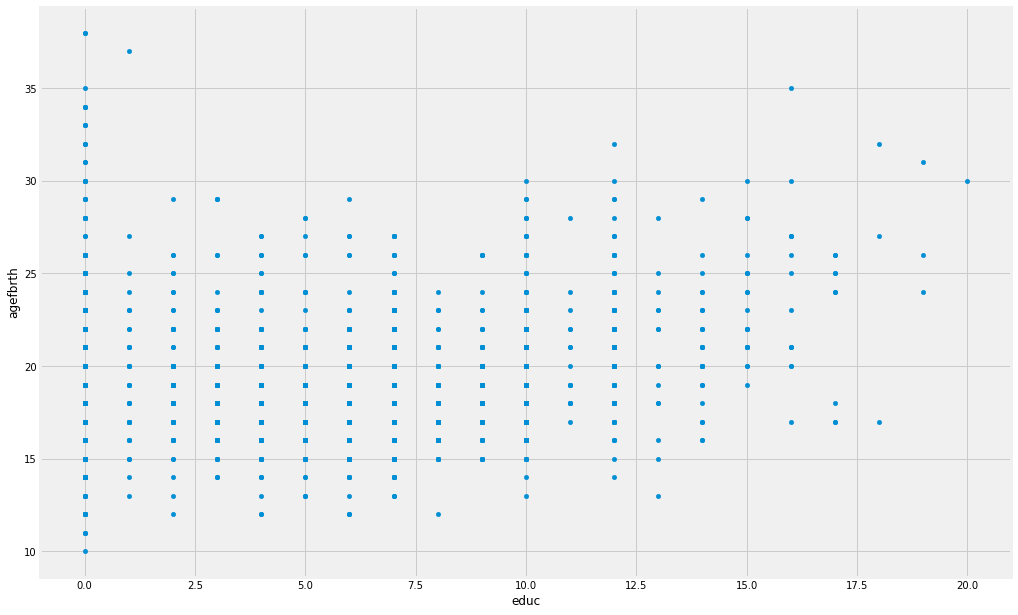

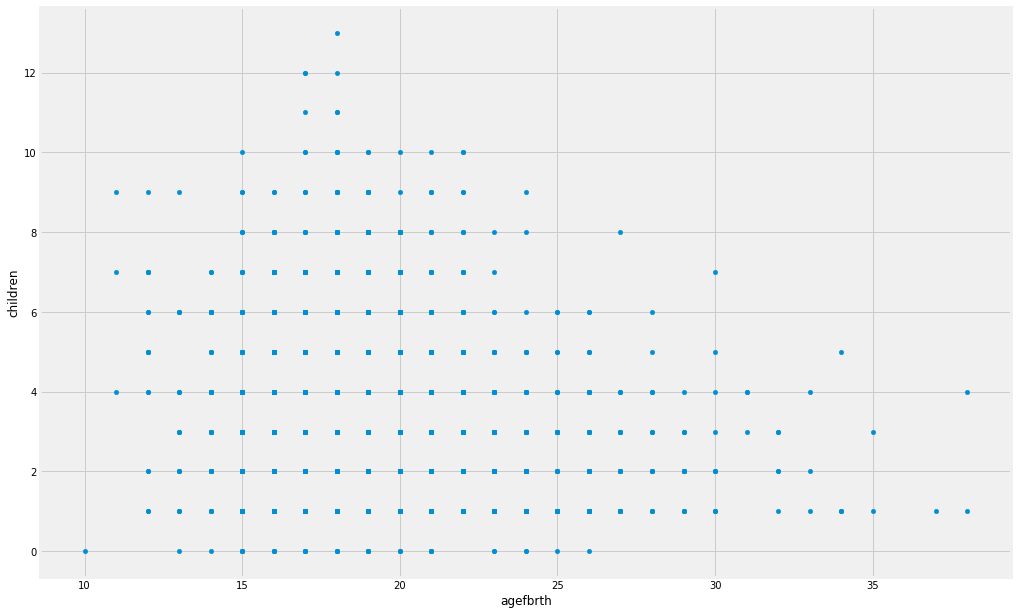

In [5]:
rcParams['figure.figsize'] = 15.5, 10.5
fertility.plot.scatter('educ', 'agefbrth'); fertility.plot.scatter( 'agefbrth', 'children');

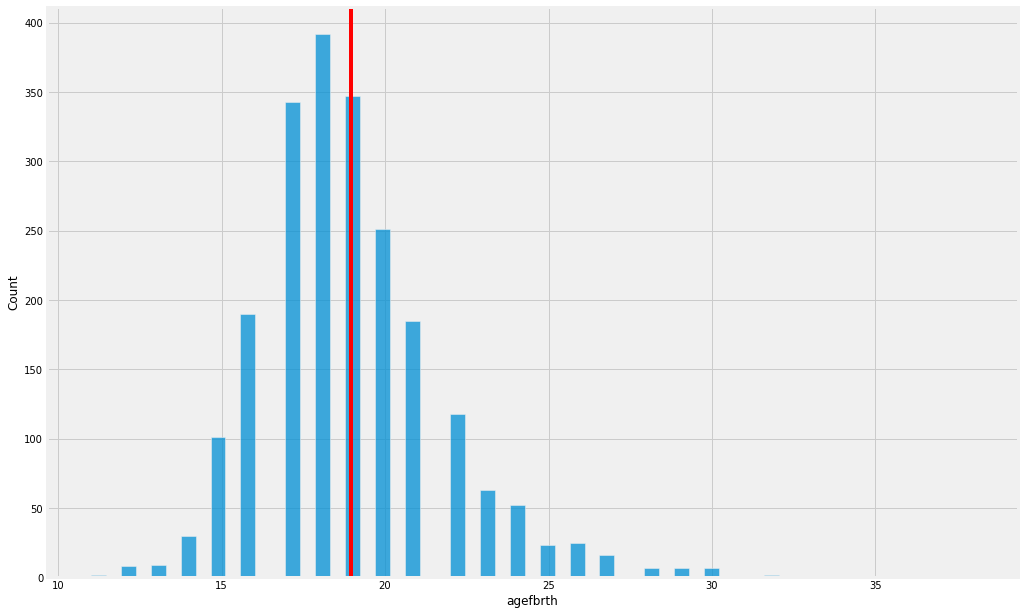

In [6]:
sns.histplot(fertility[fertility['usemeth'] == 1]['agefbrth'].dropna())
plt.axvline(np.mean(fertility[fertility['usemeth'] == 1]['agefbrth']), color ='red')

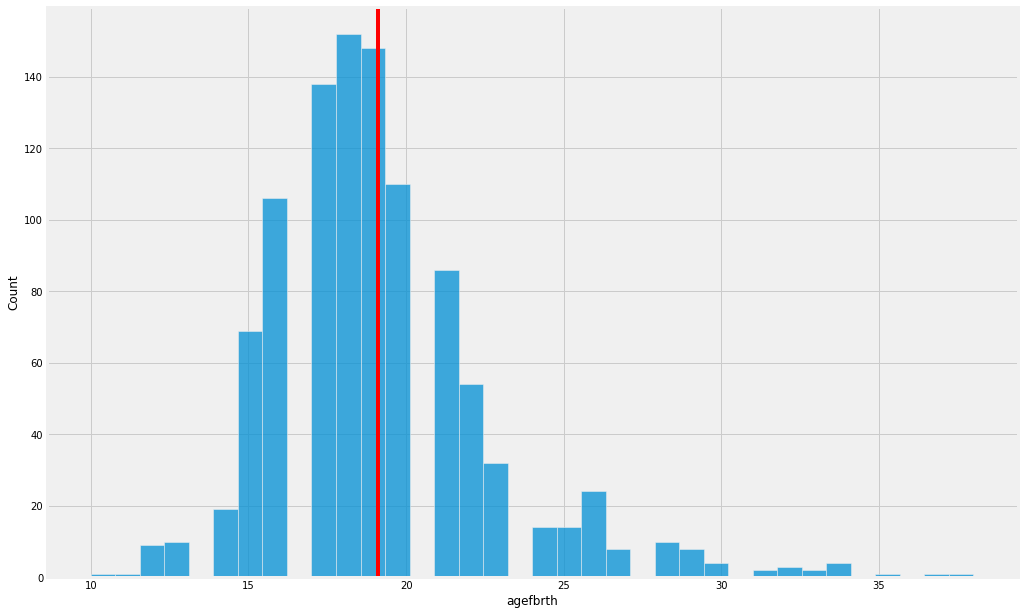

In [7]:
sns.histplot(fertility[fertility['usemeth'] == 0]['agefbrth'].dropna())
plt.axvline(np.mean(fertility[fertility['usemeth'] == 0]['agefbrth']), color ='red')

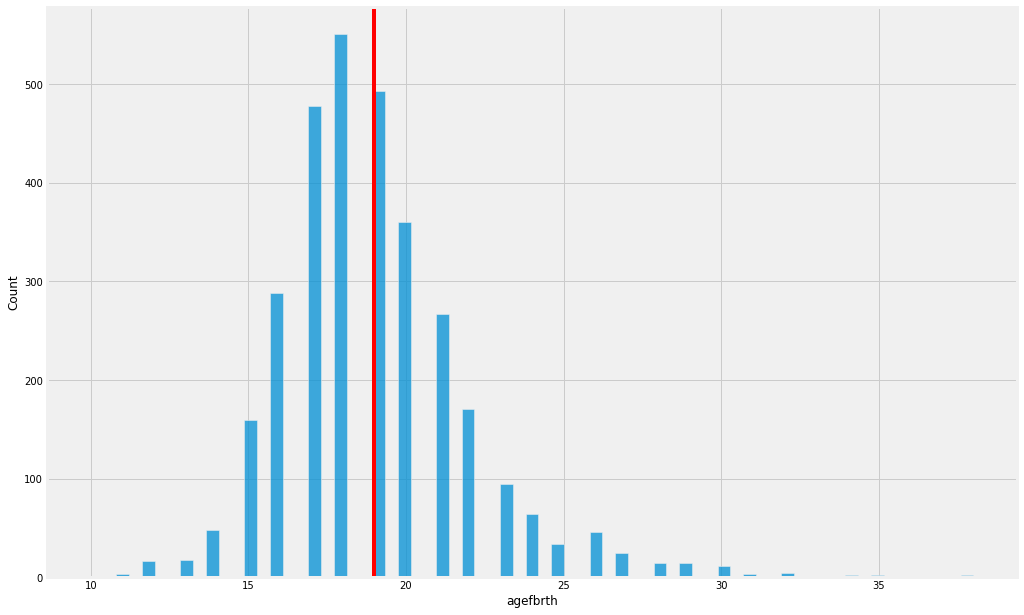

In [8]:
sns.histplot(fertility[fertility['knowmeth'] == 1]['agefbrth'].dropna())
plt.axvline(np.mean(fertility[fertility['knowmeth'] == 1]['agefbrth']), color ='red')

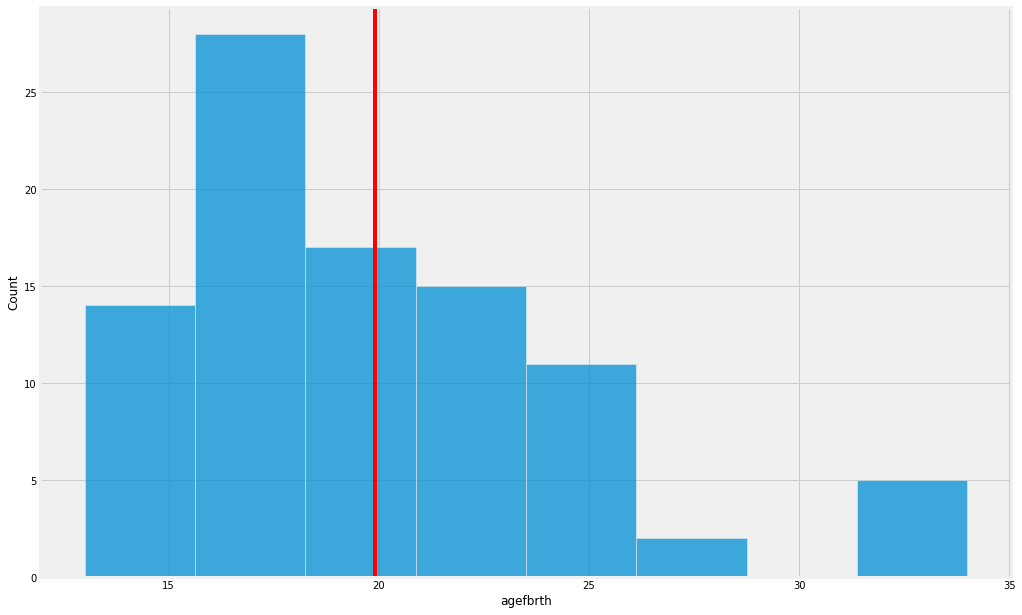

In [9]:
sns.histplot(fertility[fertility['knowmeth'] == 0]['agefbrth'].dropna())
plt.axvline(np.mean(fertility[fertility['knowmeth'] == 0]['agefbrth']), color ='red')

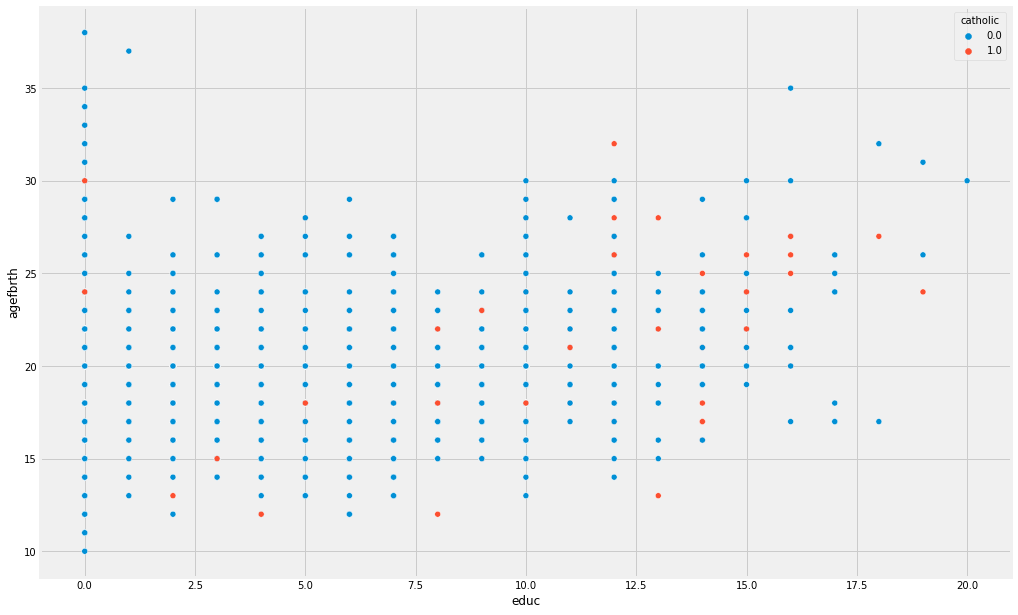

In [10]:
sns.scatterplot(data = fertility, y ='agefbrth', x = 'educ', hue="catholic")

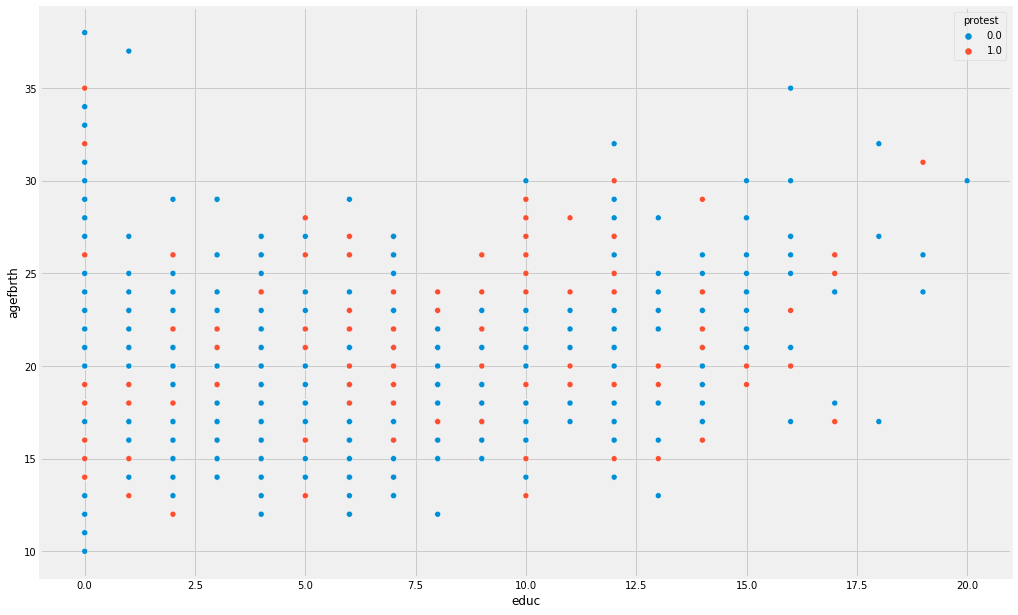

In [11]:
sns.scatterplot(data = fertility, y ='agefbrth', x = 'educ', hue="protest")

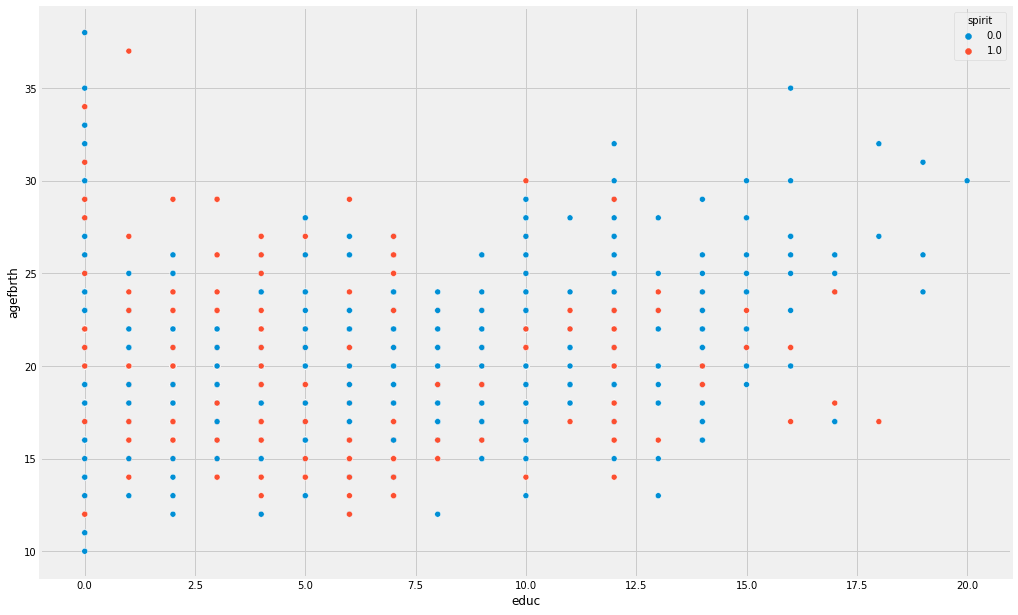

In [12]:
sns.scatterplot(data = fertility, y ='agefbrth', x = 'educ', hue="spirit")

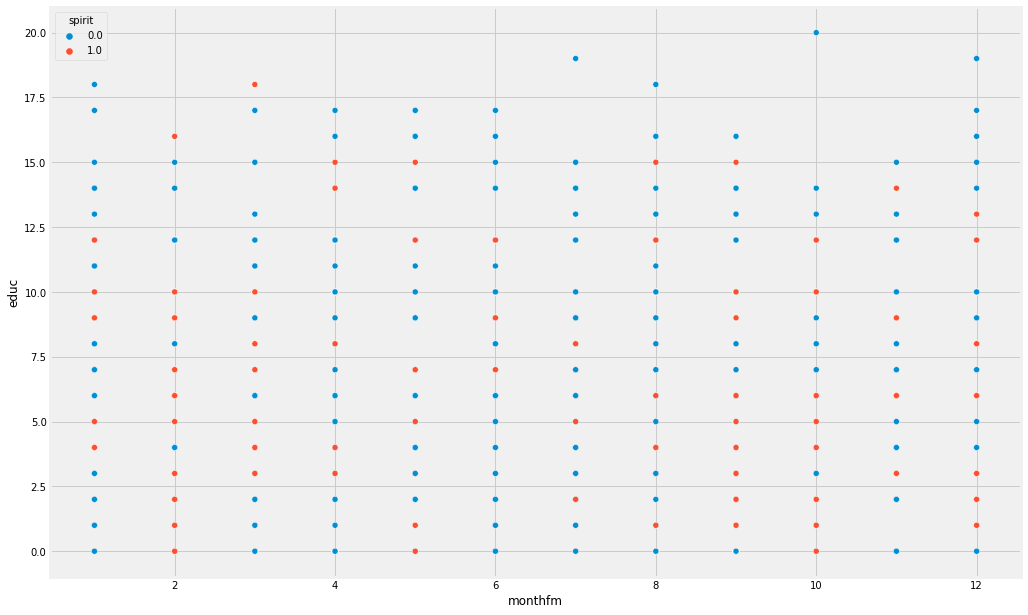

In [13]:
sns.scatterplot(data = fertility, y ='educ', x = 'monthfm', hue="spirit")

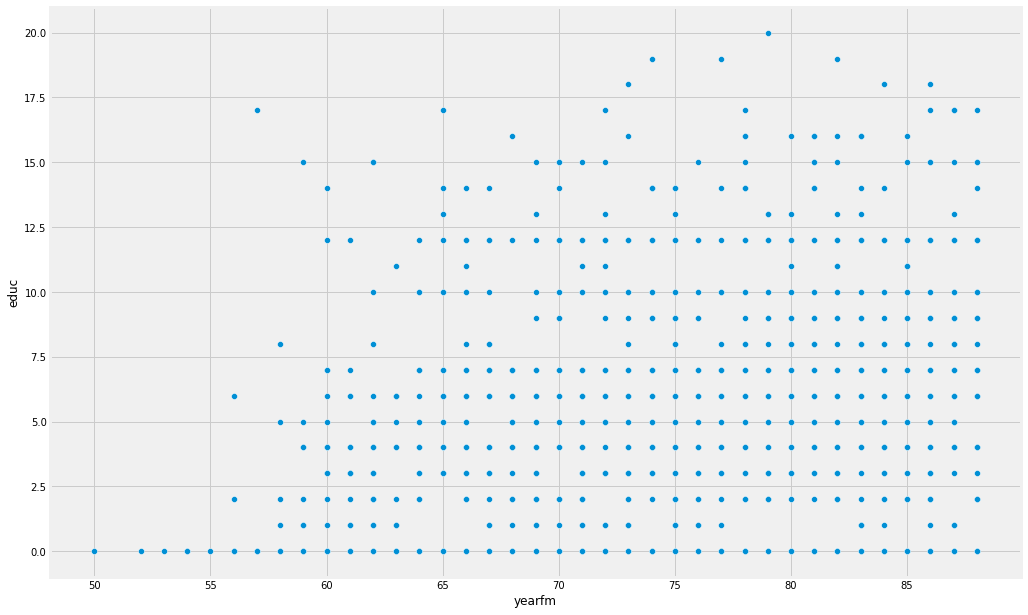

In [14]:
sns.scatterplot(data = fertility, y ='educ', x = 'yearfm')

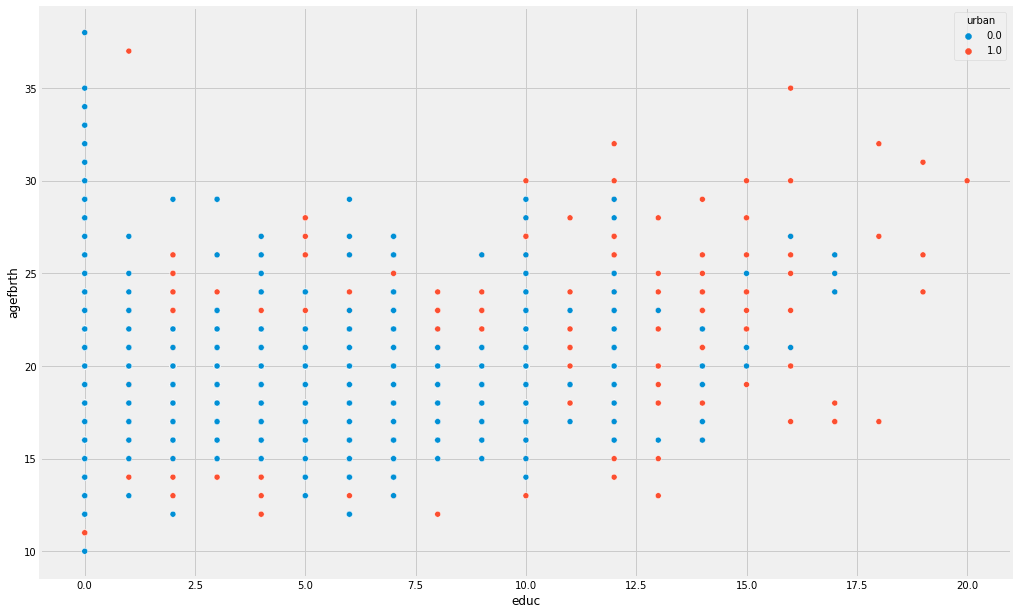

In [15]:
sns.scatterplot(data = fertility, y ='agefbrth', x = 'educ', hue="urban")

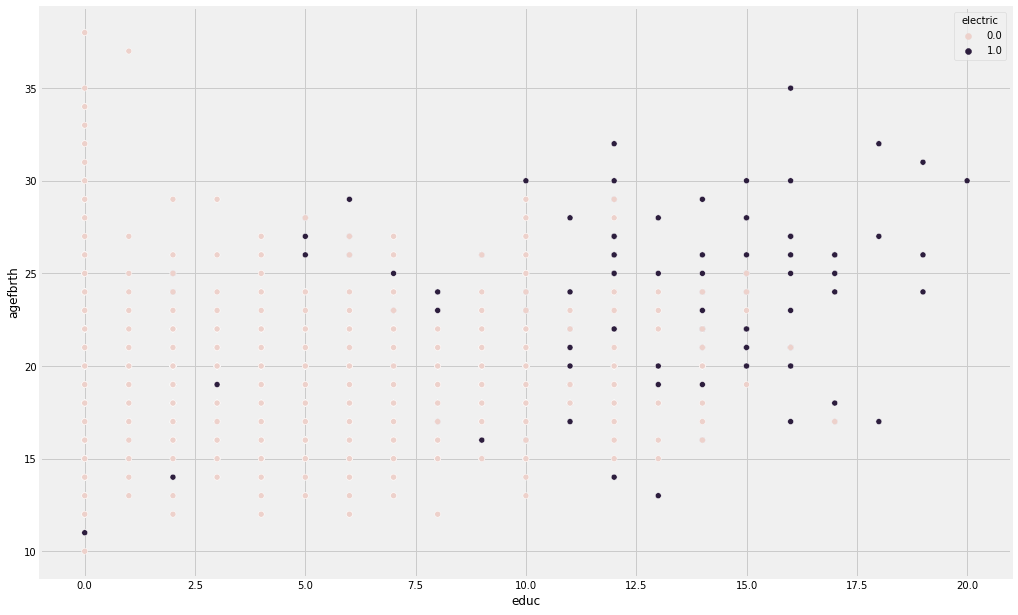

In [16]:
sns.scatterplot(data = fertility, y ='agefbrth', x = 'educ', hue="electric")

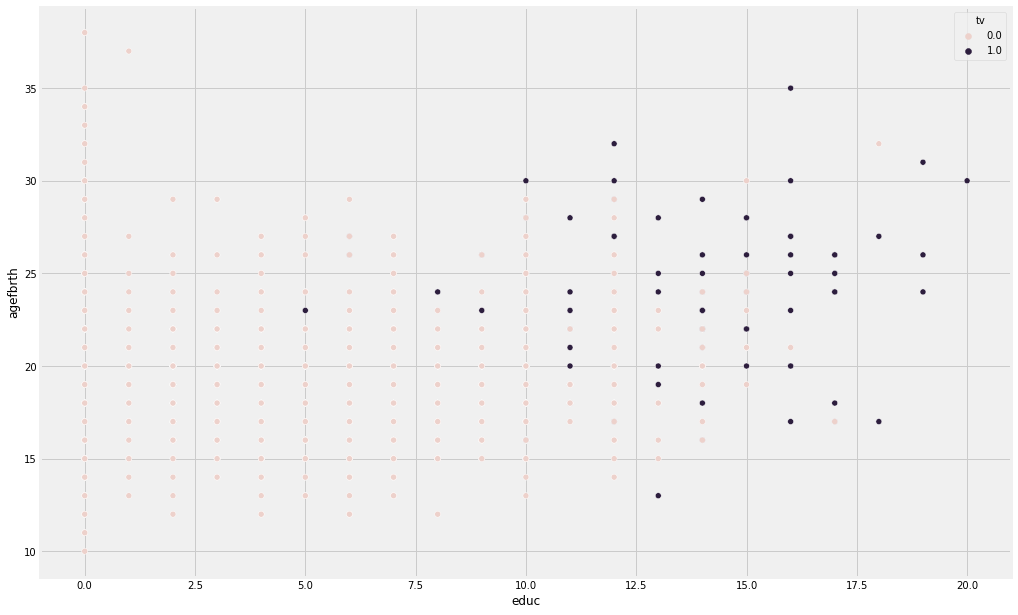

In [17]:
sns.scatterplot(data = fertility, y ='agefbrth', x = 'educ', hue="tv")

### 2. Modelos näive con endogeneidad: ¿Porque no podemos estimar el efecto causal ?

In [18]:
df = fertility.dropna()

2.1 Full Model

In [19]:
ind_vars = set(df.columns.tolist()) - set(['agefbrth'])
dep_var = 'agefbrth'
X = df[ind_vars] 
Y = df[dep_var]
X['const'] = 1

In [20]:
full_model = sm.OLS(Y, X).fit(cov_type='HC3')
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               agefbrth   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     5318.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:22:07   Log-Likelihood:                -4067.0
No. Observations:                1719   AIC:                             8186.
Df Residuals:                    1693   BIC:                             8328.
Df Model:                          25                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spirit        -0.3831      0.164     -2.338      0.019      -0.704      -0.062
educ           0.1598      0.041      3.930      0.000       0.080       0.239
protest       -0.3462      0.200     -1.732      0.083      -0.738       0.045
catholic      -0.4394      0.256     -1.719      0.086      -0.941       0.062
ceb           -0.6834      0.120     -5.718      0.000      -0.918      -0.449
yearfm        -0.0082      0.211     -0.039      0.969      -0.421       0.404
idlnchld      -0.0133      0.030     -0.451      0.652      -0.071       0.045
educ0          0.9811      0.251      3.909      0.000       0.489       1.473
electric       0.2778      0.195      1.426      0.154      -0.104       0.660
frsthalf       0.0241      0.241      0.100      0.920      -0.447       0.496
age            0.0895      0.241      0.371      0.711      -0.384       0.563
knowmeth      -0.4693      0.577     -0.813      0.416      -1.600       0.662
monthfm        0.0219      0.025      0.864      0.388      -0.028       0.072
agefm          0.1706      0.210      0.814      0.416      -0.240       0.582
bicycle        0.1219      0.141      0.863      0.388      -0.155       0.399
tv            -0.0199      0.270     -0.074      0.941      -0.549       0.509
heduc         -0.0166      0.018     -0.921      0.357      -0.052       0.019
radio         -0.3172      0.156     -2.032      0.042      -0.623      -0.011
mnthborn      -0.0746      0.043     -1.743      0.081      -0.158       0.009
yearborn      -0.2424      0.307     -0.791      0.429      -0.843       0.359
usemeth        0.0342      0.163      0.210      0.833      -0.284       0.353
agesq         -0.0018      0.001     -1.457      0.145      -0.004       0.001
evermarr      15.8818     10.180      1.560      0.119      -4.071      35.834
urban         -0.8140      0.241     -3.384      0.001      -1.285      -0.343
children       0.0584      0.120      0.487      0.626      -0.176       0.293
urbeduc        0.0758      0.036      2.079      0.038       0.004       0.147
const         15.8818     10.180      1.560      0.119      -4.071      35.834
==============================================================================
Omnibus:                      111.612   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              354.818
Skew:                           0.278   Prob(JB):                     8.96e-78
Kurtosis:                       5.155   Cond. No.                     1.23e+16
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 1.68e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

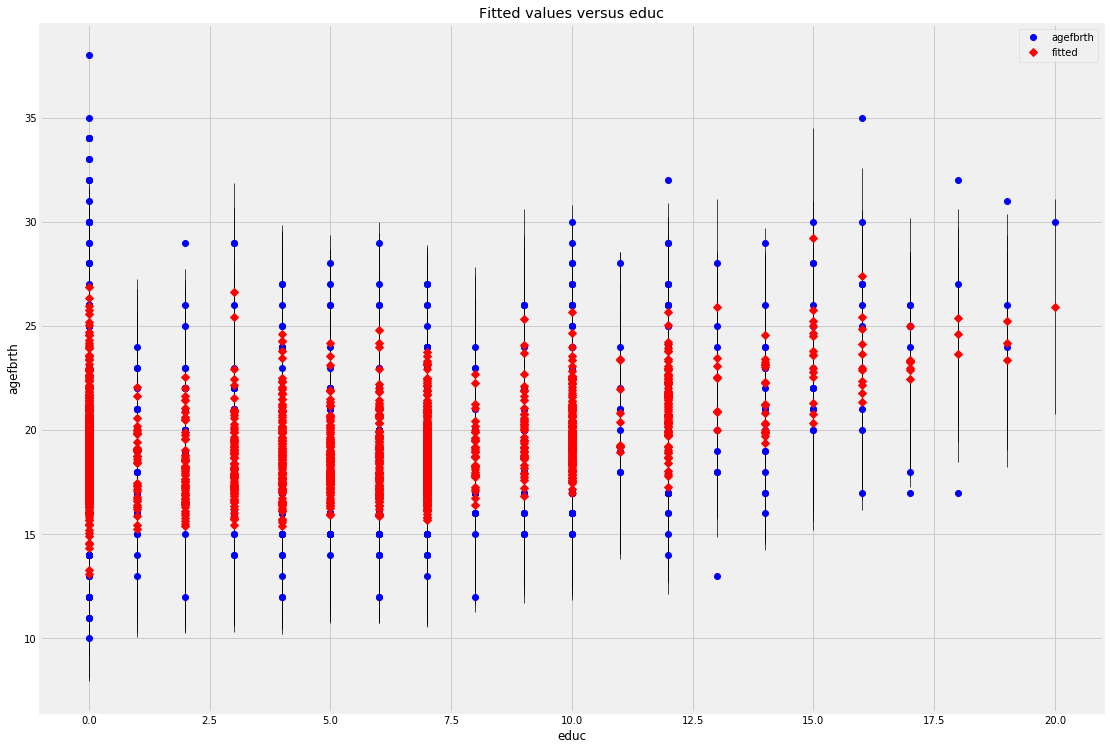

In [21]:
fig = sm.graphics.plot_fit(full_model, "educ")
fig.tight_layout(pad=1.0)

In [56]:
#fig = sm.graphics.plot_partregress_grid(full_model)
#fig.tight_layout(pad=1.0)

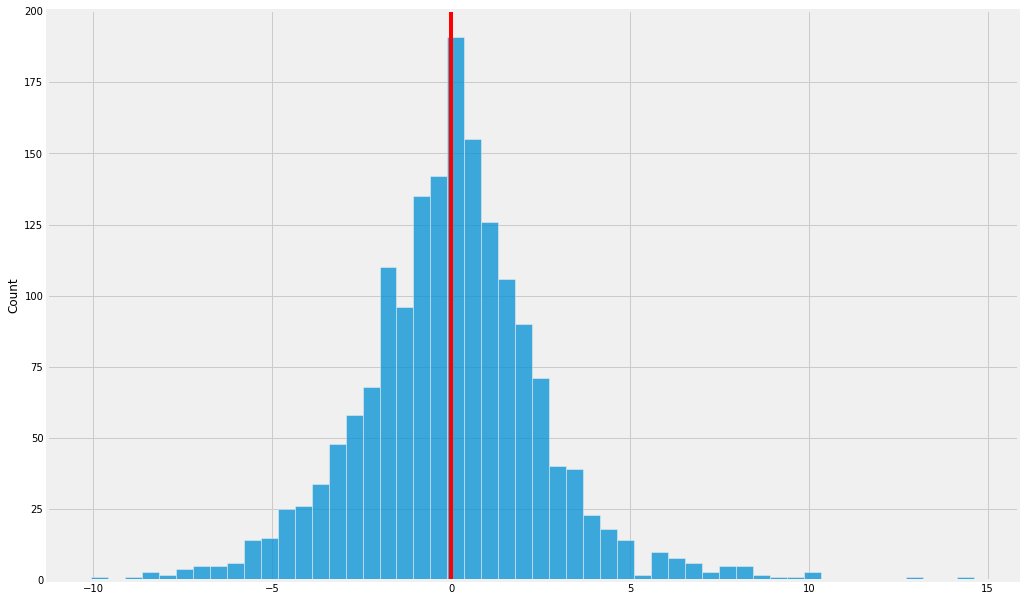

In [58]:
sns.histplot(full_model.resid)
plt.axvline(np.mean(full_model.resid), color ='red')

2.2 Fixed Effects Model

In [67]:
ind_vars = ['electric', 'radio', 'tv', 'bicycle', 'knowmeth', 'usemeth', 'urban', 'spirit', 'protest', 'catholic', 'educ0', 'educ']
dep_var = 'agefbrth'
X = df[ind_vars].copy() 
Y = df[dep_var].copy()
X['const'] = 1

In [68]:
fixed_effects_model = sm.OLS(Y, X).fit(cov_type='HC3')
fixed_effects_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               agefbrth   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     12.21
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           3.73e-24
Time:                        18:20:30   Log-Likelihood:                -4397.6
No. Observations:                1719   AIC:                             8821.
Df Residuals:                    1706   BIC:                             8892.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
electric       0.6354      0.255      2.489      0.013       0.135       1.136
radio         -0.2662      0.187     -1.422      0.155      -0.633       0.101
tv             0.7620      0.315      2.417      0.016       0.144       1.380
bicycle       -0.0149      0.159     -0.094      0.925      -0.326       0.296
knowmeth      -1.7044      0.762     -2.237      0.025      -3.198      -0.211
usemeth       -0.5094      0.190     -2.681      0.007      -0.882      -0.137
urban         -0.4065      0.153     -2.650      0.008      -0.707      -0.106
spirit        -0.3165      0.201     -1.575      0.115      -0.710       0.077
protest        0.0559      0.238      0.235      0.815      -0.411       0.523
catholic      -0.0840      0.312     -0.269      0.788      -0.696       0.528
educ0          1.2839      0.281      4.564      0.000       0.733       1.835
educ           0.2583      0.034      7.595      0.000       0.192       0.325
const         19.8405      0.778     25.493      0.000      18.315      21.366
==============================================================================
Omnibus:                      388.050   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1170.553
Skew:                           1.137   Prob(JB):                    6.57e-255
Kurtosis:                       6.343   Cond. No.                         60.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

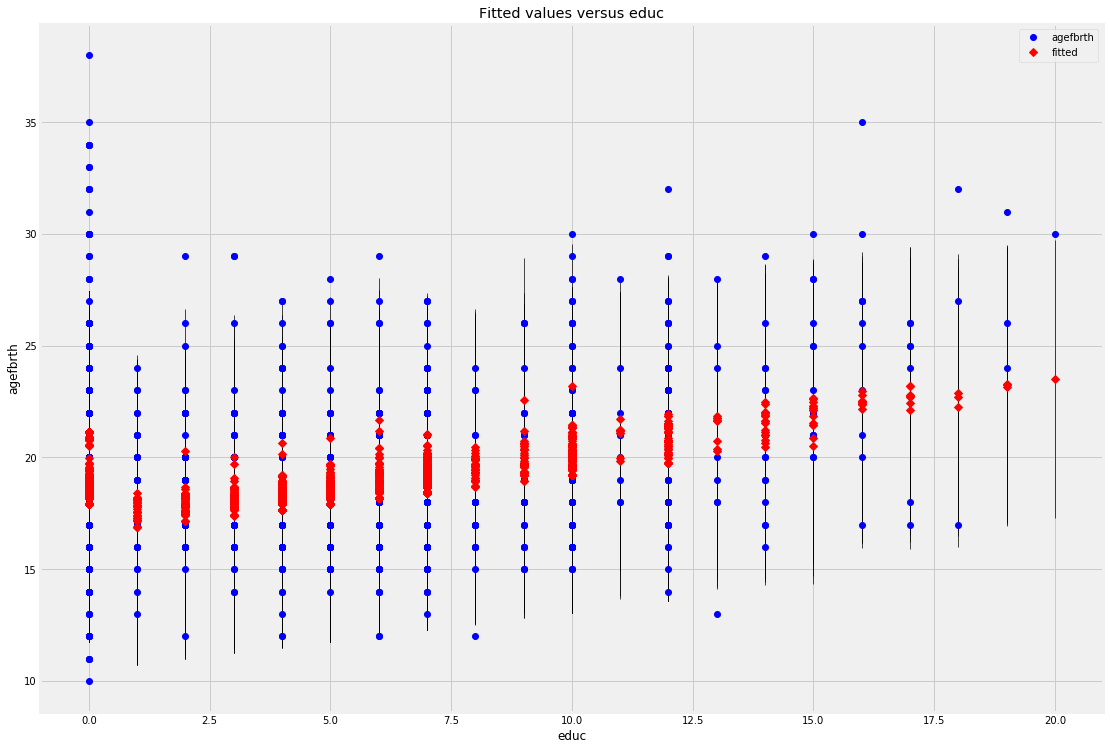

In [69]:
fig = sm.graphics.plot_fit(fixed_effects_model, "educ")
fig.tight_layout(pad=1.0)

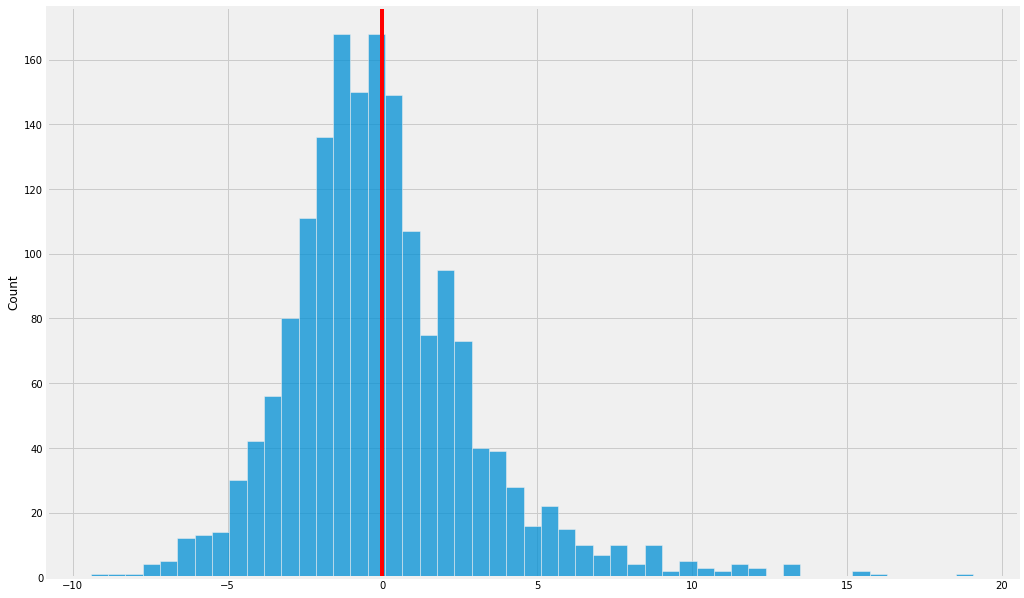

In [70]:
sns.histplot(fixed_effects_model.resid)
plt.axvline(np.mean(fixed_effects_model.resid), color ='red')

2.3 Parsimonious Model (Occam's Razor modeling approach)

In [60]:
ind_vars = ['monthfm', 'ceb', 'educ', 'idlnchld']
dep_var = 'agefbrth'
X = df[ind_vars].copy() 
Y = df[dep_var].copy()
X['const'] = 1

In [61]:
parsimonious_model = sm.OLS(Y, X).fit(cov_type='HC3')
parsimonious_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               agefbrth   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     24.34
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           1.29e-19
Time:                        18:19:12   Log-Likelihood:                -4441.8
No. Observations:                1719   AIC:                             8894.
Df Residuals:                    1714   BIC:                             8921.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
monthfm        0.0447      0.022      2.077      0.038       0.003       0.087
ceb           -0.1686      0.036     -4.642      0.000      -0.240      -0.097
educ           0.1290      0.025      5.162      0.000       0.080       0.178
idlnchld      -0.0154      0.035     -0.443      0.658      -0.084       0.053
const         18.9776      0.341     55.590      0.000      18.309      19.647
==============================================================================
Omnibus:                      478.231   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1584.383
Skew:                           1.366   Prob(JB):                         0.00
Kurtosis:                       6.828   Cond. No.                         44.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

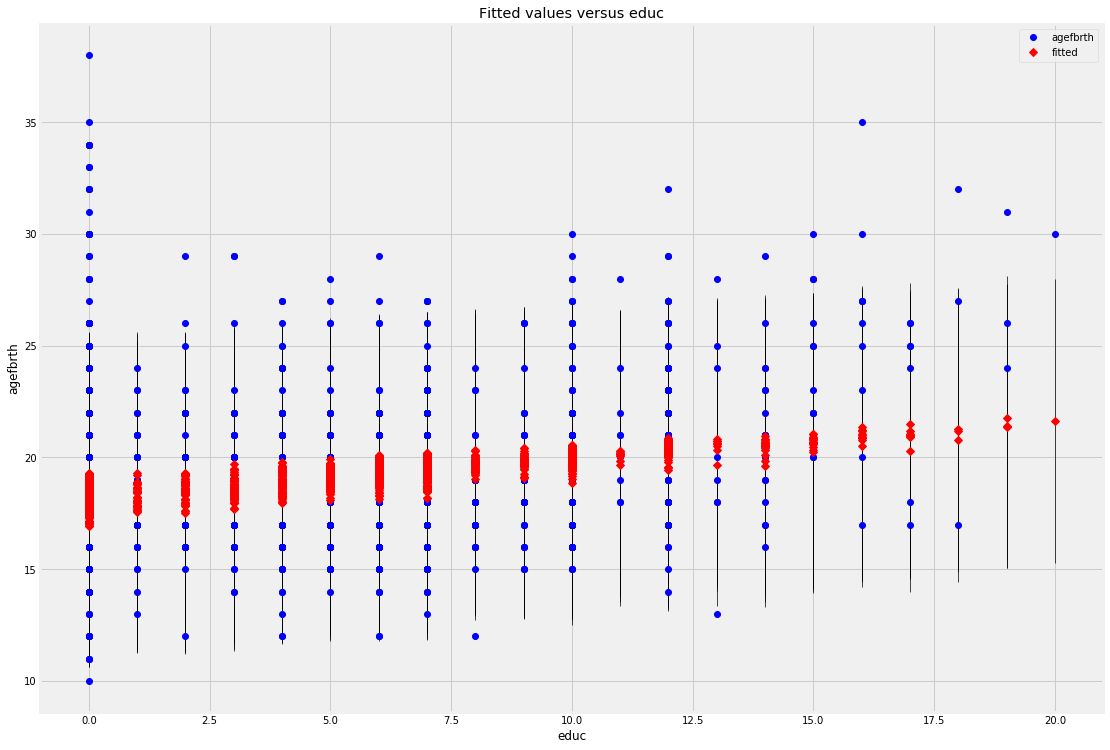

In [63]:
fig = sm.graphics.plot_fit(parsimonious_model, "educ")
fig.tight_layout(pad=1.0)

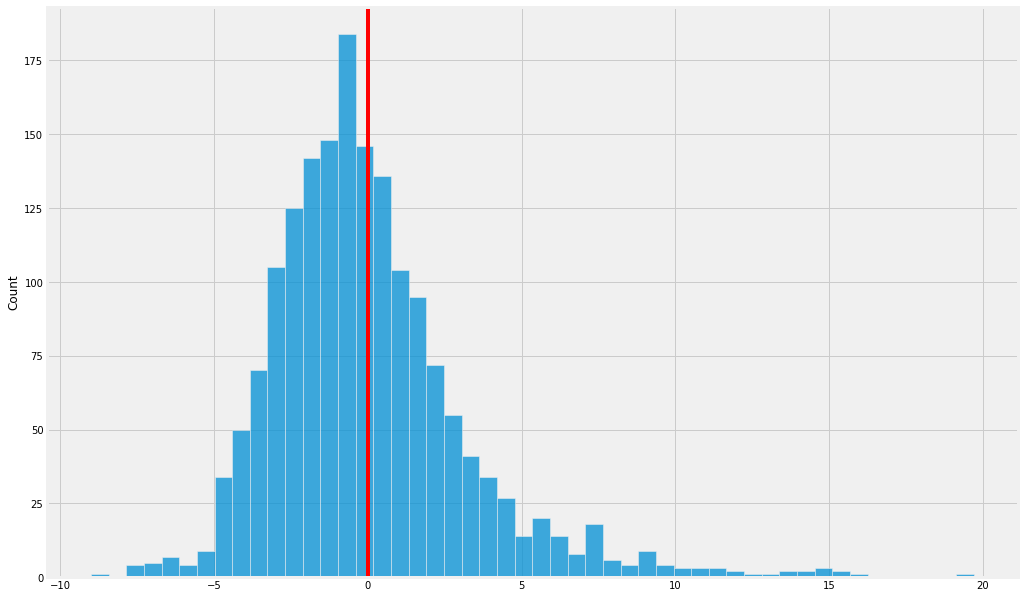

In [65]:
sns.histplot(parsimonious_model.resid)
plt.axvline(np.mean(parsimonious_model.resid), color ='red')

### 3. ¿Qué variables del data set son buenas candidatas a ser instrumentos 


1. ¿Que tan correlacionado esta el instrumento con la variable endogena?
2. ¿Que tan fuerte es el instrumento?

In [24]:
fertility.columns

Index(['mnthborn', 'yearborn', 'age', 'electric', 'radio', 'tv', 'bicycle',
       'educ', 'ceb', 'agefbrth', 'children', 'knowmeth', 'usemeth', 'monthfm',
       'yearfm', 'agefm', 'idlnchld', 'heduc', 'agesq', 'urban', 'urbeduc',
       'spirit', 'protest', 'catholic', 'frsthalf', 'educ0', 'evermarr'],
      dtype='object')

Set de posibles instrumentos = {electric, radio, tv, urban}

In [22]:
rel = ['monthfm', 'ceb', 'electric']
endog = 'educ'
dropped_na = fertility[(fertility.monthfm.notnull()) & (fertility.ceb.notnull()) & (fertility.electric.notnull())
                    & (fertility.educ.notnull())]
only_exog = sm.add_constant(dropped_na[rel])
relevancy_results = sm.OLS(dropped_na[endog], only_exog).fit()
relevancy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     253.9
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          2.70e-140
Time:                        17:54:55   Log-Likelihood:                -5605.4
No. Observations:                2076   AIC:                         1.122e+04
Df Residuals:                    2072   BIC:                         1.124e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7469      0.205     27.973      0.000       5.344       6.150
monthfm        0.0220      0.022      1.007      0.314      -0.021       0.065
ceb           -0.4456      0.032    -13.811      0.000      -0.509      -0.382
electric       4.6753      0.216     21.634      0.000       4.251       5.099
==============================================================================
Omnibus:                       38.041   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.335
Skew:                           0.100   Prob(JB):                     8.57e-06
Kurtosis:                       2.521   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
hypothesis = '(electric = 0)'
print(relevancy_results.f_test(hypothesis))

<F test: F=468.013714022873, p=9.542931200264737e-94, df_denom=2.07e+03, df_num=1>


In [25]:
rel = ['monthfm', 'ceb', 'tv']
endog = 'educ'
dropped_na = fertility[(fertility.monthfm.notnull()) & (fertility.ceb.notnull()) & (fertility.tv.notnull())
                    & (fertility.educ.notnull())]
only_exog = sm.add_constant(dropped_na[rel])
relevancy_results = sm.OLS(dropped_na[endog], only_exog).fit()
relevancy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     281.2
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          3.99e-153
Time:                        17:57:28   Log-Likelihood:                -5575.7
No. Observations:                2076   AIC:                         1.116e+04
Df Residuals:                    2072   BIC:                         1.118e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8823      0.200     29.375      0.000       5.490       6.275
monthfm        0.0166      0.022      0.771      0.441      -0.026       0.059
ceb           -0.4451      0.032    -14.012      0.000      -0.507      -0.383
tv             5.7306      0.246     23.272      0.000       5.248       6.214
==============================================================================
Omnibus:                       28.370   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.146
Skew:                           0.073   Prob(JB):                     0.000115
Kurtosis:                       2.566   Cond. No.                         26.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
hypothesis = '(tv = 0)'
print(relevancy_results.f_test(hypothesis))

<F test: F=541.5781466825158, p=1.2837983338905017e-106, df_denom=2.07e+03, df_num=1>


In [29]:
rel = ['monthfm', 'ceb', 'radio']
endog = 'educ'
dropped_na = fertility[(fertility.monthfm.notnull()) & (fertility.ceb.notnull()) & (fertility.radio.notnull())
                    & (fertility.educ.notnull())]
only_exog = sm.add_constant(dropped_na[rel])
relevancy_results = sm.OLS(dropped_na[endog], only_exog).fit()
relevancy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     160.4
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           1.67e-93
Time:                        17:58:07   Log-Likelihood:                -5713.5
No. Observations:                2076   AIC:                         1.143e+04
Df Residuals:                    2072   BIC:                         1.146e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9827      0.248     20.098      0.000       4.496       5.469
monthfm        0.0083      0.023      0.362      0.717      -0.037       0.054
ceb           -0.5155      0.034    -15.301      0.000      -0.582      -0.449
radio          2.6811      0.182     14.722      0.000       2.324       3.038
==============================================================================
Omnibus:                       20.818   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.778
Skew:                           0.227   Prob(JB):                     3.08e-05
Kurtosis:                       2.817   Cond. No.                         26.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
hypothesis = '(radio = 0)'
print(relevancy_results.f_test(hypothesis))

<F test: F=216.7394276352314, p=9.80629590414866e-47, df_denom=2.07e+03, df_num=1>


In [31]:
rel = ['monthfm', 'ceb', 'urban']
endog = 'educ'
dropped_na = fertility[(fertility.monthfm.notnull()) & (fertility.ceb.notnull()) & (fertility.urban.notnull())
                    & (fertility.educ.notnull())]
only_exog = sm.add_constant(dropped_na[rel])
relevancy_results = sm.OLS(dropped_na[endog], only_exog).fit()
relevancy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     128.0
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           4.54e-76
Time:                        17:58:28   Log-Likelihood:                -5753.8
No. Observations:                2076   AIC:                         1.152e+04
Df Residuals:                    2072   BIC:                         1.154e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5458      0.246     22.528      0.000       5.063       6.029
monthfm        0.0169      0.023      0.718      0.473      -0.029       0.063
ceb           -0.4611      0.035    -13.135      0.000      -0.530      -0.392
urban          1.9852      0.174     11.382      0.000       1.643       2.327
==============================================================================
Omnibus:                       33.045   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.667
Skew:                           0.297   Prob(JB):                     4.89e-08
Kurtosis:                       2.811   Cond. No.                         25.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
hypothesis = '(urban = 0)'
print(relevancy_results.f_test(hypothesis))

<F test: F=129.5530286017251, p=3.697674484406698e-29, df_denom=2.07e+03, df_num=1>


Rankeando por relevancia (validez) y fuerza quedan TV, Electric, Radio y Urban.

### 4. Una vez escogido un tipo de modelo, compare los efectos causales utilizando OLS vs diseño de variable instrumental.

In [71]:
ind_vars = ['monthfm', 'ceb', 'educ', 'idlnchld']
dep_var = 'agefbrth'
X = df[ind_vars].copy() 
Y = df[dep_var].copy()
X['const'] = 1

In [72]:
no_null_iv = fertility[(fertility['agefbrth'].notnull()) & (fertility['tv'].notnull()) & 
                    (fertility['monthfm'].notnull()) & (fertility['ceb'].notnull()) & (fertility['educ'].notnull())
                      & (fertility['idlnchld'].notnull())]
endog = no_null_iv['agefbrth']
exog = no_null_iv[['monthfm', 'ceb', 'idlnchld', 'educ']]
instr = no_null_iv[['monthfm', 'ceb', 'idlnchld', 'tv']]
dep_var_iv = no_null_iv['agefbrth']

exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
no_endog_results = IV2SLS(endog, exog_constant, instrument = instr_constant).fit()

no_endog_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:               agefbrth   R-squared:                      -0.005
Model:                         IV2SLS   Adj. R-squared:                 -0.007
Method:                     Two Stage   F-statistic:                     30.94
                        Least Squares   Prob (F-statistic):           5.66e-25
Date:                Wed, 21 Jun 2023                                         
Time:                        18:21:39                                         
No. Observations:                1871                                         
Df Residuals:                    1866                                         
Df Model:                           4                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9347      0.482     35.137      0.000      15.989      17.880
monthfm        0.0412      0.021      1.972      0.049       0.000       0.082
ceb           -0.0545      0.040     -1.346      0.178      -0.134       0.025
idlnchld       0.0859      0.039      2.181      0.029       0.009       0.163
educ           0.3441      0.045      7.689      0.000       0.256       0.432
==============================================================================
Omnibus:                      528.669   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1894.680
Skew:                           1.362   Prob(JB):                         0.00
Kurtosis:                       7.109   Cond. No.                         43.8
==============================================================================
"""

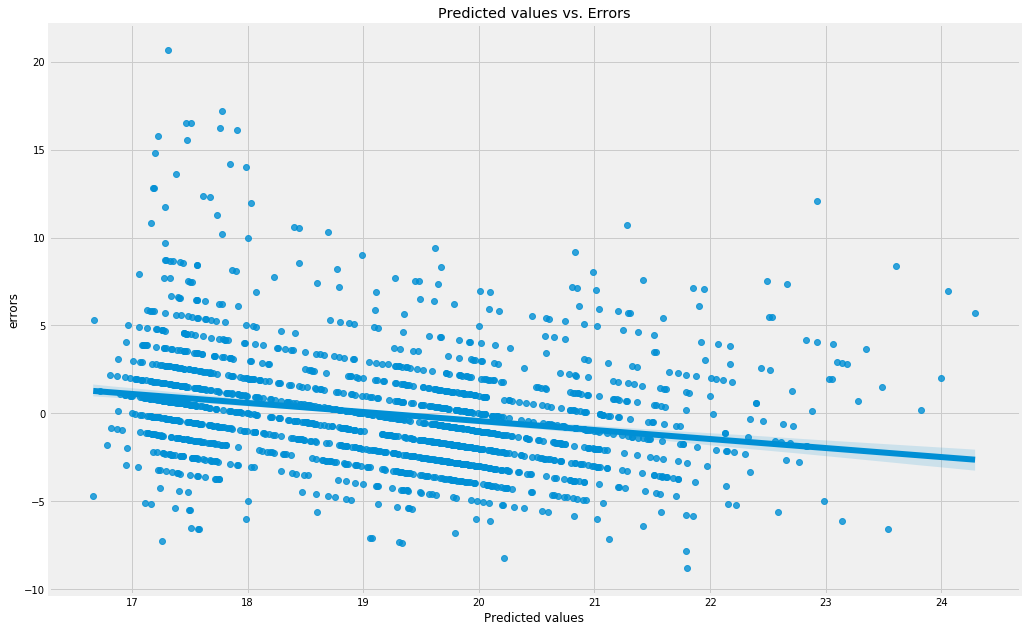

In [73]:
print_resids(no_endog_results.predict(), no_endog_results.resid)

Parece ser un buen resultado! Sin embargo tenemos que validar el supuesto de exclusión, para eso realizamos un test de Hausman-Wu para testear endogeneidad de TV con educacion!

In [74]:
rel = ['monthfm', 'ceb', 'educ', 'idlnchld', 'tv']
endog = 'educ'
dropped_na = fertility[(fertility.monthfm.notnull()) & (fertility.ceb.notnull()) & (fertility.tv.notnull())
                    & (fertility.educ.notnull()) &  (fertility.idlnchld.notnull())]
only_exog = sm.add_constant(dropped_na[rel])
relevancy_results = sm.OLS(dropped_na[endog], only_exog).fit()
relevancy_results.summary()

# add relevancy equation residuals on to the endogenous matrix
X['relevancy_resids'] = relevancy_results.resid

# run endogenous regression now with residuals added in
endog_test_results = sm.OLS(Y, X, missing = 'drop').fit()

endog_test_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               agefbrth   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     27.04
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           8.63e-22
Time:                        18:24:12   Log-Likelihood:                -4441.8
No. Observations:                1719   AIC:                             8894.
Df Residuals:                    1714   BIC:                             8921.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
monthfm              0.0447      0.021      2.083      0.037       0.003       0.087
ceb                 -0.1686      0.036     -4.624      0.000      -0.240      -0.097
educ                 0.1290      0.020      6.388      0.000       0.089       0.169
idlnchld            -0.0154      0.036     -0.428      0.669      -0.086       0.055
const               18.9776      0.316     60.088      0.000      18.358      19.597
relevancy_resids -1.571e-13   2.61e-15    -60.183      0.000   -1.62e-13   -1.52e-13
==============================================================================
Omnibus:                      478.231   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1584.383
Skew:                           1.366   Prob(JB):                         0.00
Kurtosis:                       6.828   Cond. No.                     9.66e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.19e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [75]:
null_hypothesis = '(relevancy_resids = 0)'
print (endog_test_results.f_test(null_hypothesis))

<F test: F=3621.9433163499184, p=0.0, df_denom=1.71e+03, df_num=1>


Pasamos el test de Hasuman-Wu! Intuitivamente esto quiere que los residuos incluyen solo información endógena de la educación porque explicamos toda la información exógena con "monthfm" y "ceb". Si podemos utilizar esa información endógena para predecir "y" de manera significativa (es decir, el coeficiente no es cero), entonces eso es evidencia de que la educación está correlacionada con la edad del primer parto a través del término de error.

Diseño alternativo: Electric como instrumento

In [76]:
no_null_iv = fertility[(fertility['agefbrth'].notnull()) & (fertility['electric'].notnull()) & 
                    (fertility['monthfm'].notnull()) & (fertility['ceb'].notnull()) & (fertility['educ'].notnull())
                      & (fertility['idlnchld'].notnull())]
endog = no_null_iv['agefbrth']
exog = no_null_iv[['monthfm', 'ceb', 'idlnchld', 'educ']]
instr = no_null_iv[['monthfm', 'ceb', 'idlnchld', 'electric']]
dep_var_iv = no_null_iv['agefbrth']

exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
no_endog_results = IV2SLS(endog, exog_constant, instrument = instr_constant).fit()

no_endog_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:               agefbrth   R-squared:                       0.005
Model:                         IV2SLS   Adj. R-squared:                  0.003
Method:                     Two Stage   F-statistic:                     28.06
                        Least Squares   Prob (F-statistic):           1.15e-22
Date:                Wed, 21 Jun 2023                                         
Time:                        18:26:48                                         
No. Observations:                1870                                         
Df Residuals:                    1865                                         
Df Model:                           4                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0973      0.507     33.696      0.000      16.102      18.092
monthfm        0.0411      0.021      1.973      0.049       0.000       0.082
ceb           -0.0635      0.041     -1.540      0.124      -0.144       0.017
idlnchld       0.0780      0.040      1.949      0.051      -0.000       0.156
educ           0.3277      0.048      6.829      0.000       0.234       0.422
==============================================================================
Omnibus:                      530.133   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1901.728
Skew:                           1.366   Prob(JB):                         0.00
Kurtosis:                       7.116   Cond. No.                         43.8
==============================================================================
"""

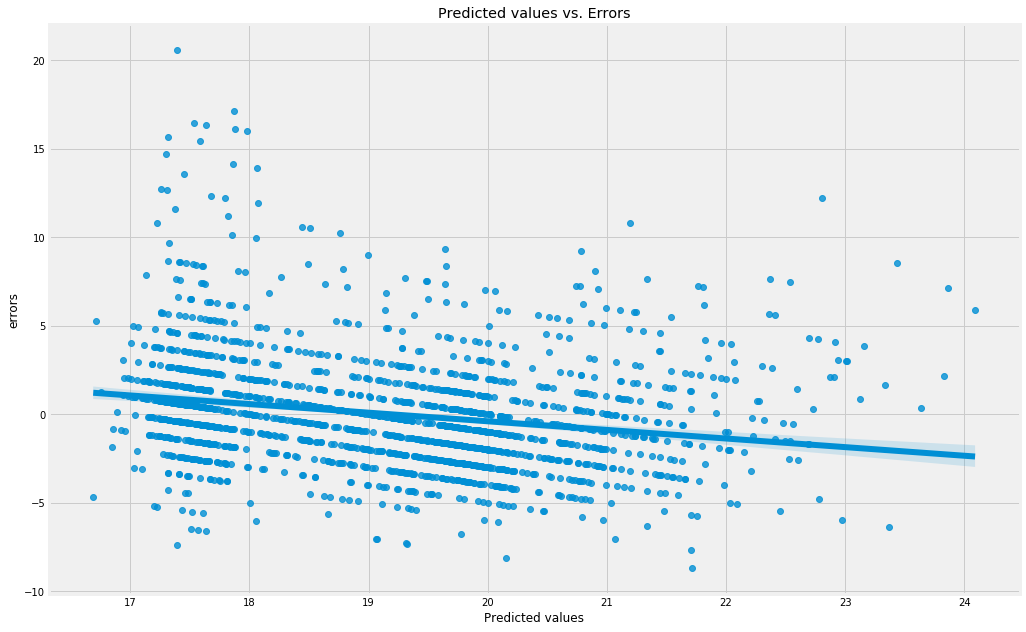

In [77]:
print_resids(no_endog_results.predict(), no_endog_results.resid)

In [78]:
rel = ['monthfm', 'ceb', 'educ', 'idlnchld', 'electric'] 
endog = 'educ'
dropped_na = fertility[(fertility.monthfm.notnull()) & (fertility.ceb.notnull()) & (fertility.electric.notnull())
                    & (fertility.educ.notnull()) & (fertility.idlnchld.notnull())]
only_exog = sm.add_constant(dropped_na[rel])
relevancy_results = sm.OLS(dropped_na[endog], only_exog).fit()
relevancy_results.summary()

# add relevancy equation residuals on to the endogenous matrix
X['relevancy_resids'] = relevancy_results.resid

# run endogenous regression now with residuals added in
endog_test_results = sm.OLS(Y, X, missing = 'drop').fit()

endog_test_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               agefbrth   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     27.04
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           8.63e-22
Time:                        18:27:50   Log-Likelihood:                -4441.8
No. Observations:                1719   AIC:                             8894.
Df Residuals:                    1714   BIC:                             8921.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
monthfm              0.0447      0.021      2.083      0.037       0.003       0.087
ceb                 -0.1686      0.036     -4.624      0.000      -0.240      -0.097
educ                 0.1290      0.020      6.388      0.000       0.089       0.169
idlnchld            -0.0154      0.036     -0.428      0.669      -0.086       0.055
const               18.9776      0.316     60.088      0.000      18.358      19.597
relevancy_resids  1.582e-13   2.64e-15     60.024      0.000    1.53e-13    1.63e-13
==============================================================================
Omnibus:                      478.231   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1584.383
Skew:                           1.366   Prob(JB):                         0.00
Kurtosis:                       6.828   Cond. No.                     1.65e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.51e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [79]:
null_hypothesis = '(relevancy_resids = 0)'
print (endog_test_results.f_test(null_hypothesis))

<F test: F=3602.8469328215397, p=0.0, df_denom=1.71e+03, df_num=1>
